In [11]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics

In [12]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision

In [13]:
include("../helpers/polynomial.jl")

ϕ (generic function with 2 methods)

In [14]:
delay_y, delay_u, delay_e = 3, 3, 3
poly_order = 2
output_ = ϕ(randn(delay_y + delay_u + delay_e + 1), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))


42-element Vector{Float64}:
  1.0
 -1.6502959040146323
  2.7234765708074726
 -0.11599952143259237
  0.19143353508786476
  0.013455888972590457
  0.002357909612516737
 -0.0038912485755731
 -0.0002735163866332508
  5.559737740798829e-6
 -0.5168223116873488
  0.8529097440810054
  0.05995114082141856
  ⋮
  0.16706264783078142
 -0.0033958642100226687
  0.7443281039628021
 -2.3282653590671742
  2.5565946001247193
  2.074179443445469
 -0.5701590351219812
  0.3250813253312286
  2.0425223425284322
  4.1718975197278345
 -1.4054733795269976
  1.9753554205590398

In [15]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [16]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        
        # simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k[1]
    end
end

experiment_FEM (generic function with 1 method)

In [17]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

In [18]:

df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"))[1:1000, :];
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = input_trn
# input_val = input_val

In [29]:
# find order
M1, M2, M3 = 3,3, 3
poly_order = 2
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

42

In [30]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [31]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1e-2, 1e-2))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

1.0

In [32]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_val, output_val, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=10, computeFE=false)

(0.3077679176527227, 0.038335101209303724, ([0.0, 0.0, 0.0, 0.4328235811283742, -0.16564108571753153, 0.28657510008137255, -0.08247736404570094, 0.1641060804241519, -0.07393848127224699, 0.04576966611615311  …  -1.7205520548694122, -1.7026329434342642, -1.6805552587930424, -1.6546586876824312, -1.6253645514527955, -1.59294730432542, -1.5576832056465395, -1.5197303911560849, -1.4792029465449366, -1.436174890345403], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ([0.0, 0.0, 0.0, 0.4328235811283742, -0.9244518954382822, -0.17281235601369513, -0.3399981534640821, -0.3113310883135468, -0.32492812331936266, -0.32658509607730285  …  -1.4544750956146837, -1.429804847967249, -1.3871783472525834, -1.3678629704210663, -1.3429129300085658, -1.3429748352803144, -1.3156792874872834, -1.274669242304829, -1.2324399361934493, -1.1997524971412534], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

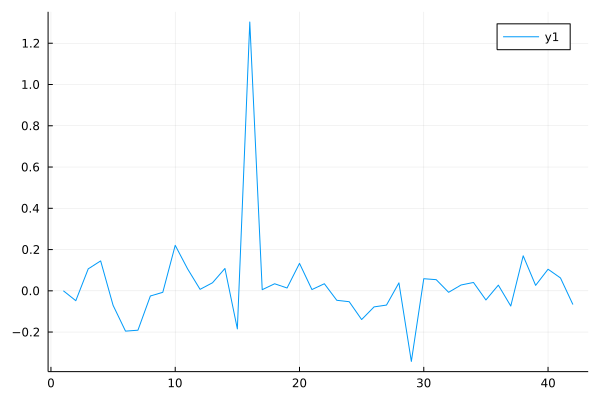

In [33]:
plot(coefs)

In [34]:
println(coefs)

[0.0001249168565140039, -0.04797386559225805, 0.10644909220635754, 0.14494394608517608, -0.07033359635400402, -0.19548617037008342, -0.19093363531995966, -0.025089384031466766, -0.007246823265066871, 0.22042006763254307, 0.10579751167241397, 0.0070610023102248565, 0.03899391045834533, 0.1083325797048835, -0.1846091154376968, 1.3030247568532456, 0.0054218063394816385, 0.03412502482878502, 0.013645103093836208, 0.1330603015154983, 0.006014909102431076, 0.03423999592665006, -0.045945631941849974, -0.05285667336036065, -0.139347826346303, -0.07796822140554782, -0.06914991178286975, 0.038524063164130956, -0.342318223901521, 0.05863394784196757, 0.05400018411157917, -0.0072497656638840224, 0.028165362488370038, 0.04043266666784362, -0.044372249821302834, 0.027515960925668215, -0.0738710400313411, 0.1696638079888273, 0.026393698803404808, 0.10458393511059594, 0.062268038035810144, -0.06649470922612188]


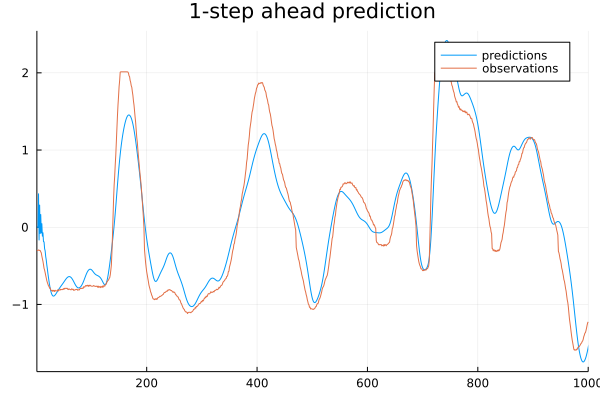

In [35]:
plot(sim[1], label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [36]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_val, output_val, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(0.5141710483453614, 0.03354691164706677, [0.0, 0.0, 0.0, -0.00020139002712765697, 0.11511586791500308, 0.2780227128105459, 0.009959056942633633, 0.09503005566892352, -0.015585112561665485, -0.04018844778326749  …  -1.515218508207047, -1.48669792877245, -1.455993807687896, -1.423507502033028, -1.3895403579022987, -1.3543133872864839, -1.3179566482950311, -1.280532860510418, -1.2420771100725092, -1.2026380784324935], [0.0, 0.0, 0.0, -0.00020139002712765697, -0.047564808085698435, -0.07686731656127493, -0.5072556070675566, -0.41011227088519137, -0.3597587005764841, -0.34028863866787534  …  -1.4477055923271676, -1.424575417485121, -1.3896833992564466, -1.3652181883202934, -1.33884540498456, -1.3304275925906017, -1.3060999012229884, -1.272329356639474, -1.2326442917403915, -1.1985309486787996], [-0.007099909169584109, -0.07246467740791386, -0.03806186993573645, -0.011030862249457296, 0.00834598837697364, 0.020675458689830173, 0.024049177432984216, 0.01578436118787918, 0.02256017849374299, 

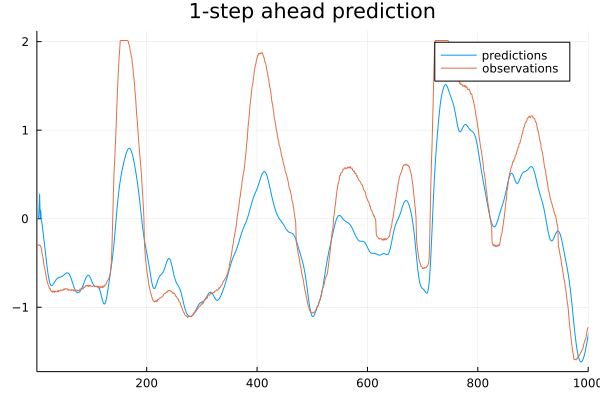

In [37]:
plot(sim, label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")